# Siamese-Conditioned GAN for Fingerprint Enhancement

## Introduction

Fingerprint recognition is essential for biometric authentication, but degraded images due to noise or low contrast often hinder accuracy. Traditional methods like Gabor filtering are limited in generalization. This notebook implements a cGAN to enhance fingerprint images, using the latent vector from a Siamese Neural Network trained on fingerprint matching as the generator's input.

Previously, we developed a Siamese Neural Network for fingerprint matching that performed well, extracting relevant features effectively. We hypothesized that using its encoder's output as the GAN's initial input would provide these features, aiding enhancement while preserving identity. This also would help prevent mode collapse, as no backpropagation would need to occur through the frozen encoder.

This work is inspired by and builds on prior works like Finger-GAN for fingerprint synthesis and FIGO for enhancement via Pix2Pix.

### Problem Statement
Degraded fingerprints challenge matching systems. Enhancement must maintain ridges, produce binary outputs, and preserve biometric identity.

### Proposed Approach
1. **Siamese Neural Network (SNN)**: Trained on auto generated dataset of fingerprints of varying quality.
2. **cGAN**: Uses SNN latents to condition generation; includes PatchGAN discriminator and L1 reconstruction loss.

### Dataset and Training
We trained on a dataset of over 800,000 synthetically generated fingerprints, created using [Anguli](https://dsl.cds.iisc.ac.in/projects/Anguli/). To improve the GAN's generalization, we incorporated varied backgrounds.

The process involves pre-training the SNN, followed by cGAN training on paired degraded-enhanced data.

Date: December 24, 2025  
Author: Dennis Kovarik


## Install Dependencies

In [ ]:
!pip install Augmentor
!pip install pillow
!pip install seaborn
!pip install torch torchvision torchaudio
!pip install scikit-image
%reload_ext autoreload
%autoreload

In [1]:
## Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms.functional as Fv
import os
import re
import time
import math
import random
import Augmentor
import numpy as np
import random
from numpy import unravel_index
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from random import Random
from skimage.util import random_noise
from IPython.display import HTML
import matplotlib.animation as animation
from collections import defaultdict
from torchvision.models import resnet18

## Config Siamese Neural Network

In [2]:
## Config Siamese Neural Network
model_results_file = "checkpoint/SSNN_results.pt"
model_ckpt_file = "checkpoint/SSNN_checkpoint.pt"

data_base_dir = "../Datasets/Fingerprint_databases/"

im_size = (300, 206)
var_max = 0.5

num_train = 10000
num_valid = 4000
num_workers = 1
shuffle = True
augment = True

sim_label = 1.0
diff_label = 0.0

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of feature maps in Siamese Neural Network
ndf = 64

# Learning rate for optimizers
slr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

## Utils

In [3]:
## Utils
def saveCkpt(filepath, epoch, netS, optimizerS, S_losses, iters):
    if os.path.isfile(filepath):
        os.remove(filepath)
    torch.save({
        'epoch' : epoch,
        'netS_state_dict' : netS.state_dict(),
        'optimizerS_state_dict' : optimizerS.state_dict(),
        'S_losses' : S_losses,
        'iters' : iters,
    }, filepath)


def showSampleFingerprintPairs(test_loader):
    # Get a Batch of Sample Images
    batch = next(iter(test_loader))
    labels = batch[2][:8]
    
    # Display the Sample Images
    plt.figure(figsize=(20,6))
    plt.subplot(2,1,1)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

    plt.subplot(2,1,2)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.show()

    c = 0
    if labels is not None:
        for l in labels:
            if l == 1:
                print("     same     ", end="")
            else:
                print("     diff     ", end="")
            if c % 4 == 0:
                print(" ", end="")
            c += 1
            
        
def validate(epoch):
    # switch to evaluate mode
    netD.eval()

    correct = 0
    total = 0
    for i, (val_Im1, val_Im2, val_y) in enumerate(valid_loader):
        with torch.no_grad():
            variation = random.uniform(0,var_max)
            val_Im1 = torch.tensor(random_noise(val_Im1, mode='gaussian', mean=0, var=variation, clip=True), dtype=torch.float32)
            val_Im1, val_Im2, val_y = val_Im1.to(device), val_Im2.to(device), val_y.to(device)
            batch_size = val_Im1.shape[0]

            # compute log probabilities
            pred = torch.round(netD(val_Im1, val_Im2))
            correct += (pred == val_y).sum().item()
            total += batch_size
            if total > num_valid:
                break

        # compute acc and log
        valid_acc = (100. * correct) / total
        return valid_acc
    
                
class AverageMeter(object):
    """
    Computes and stores the average and
    current value.
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class MovingAvg(object):
    """
    Computes the moving average of values
    """
    def __init__(self, length=10):
        self.length = length
        self.movingAvg = np.array([], dtype='f')
        
    def average(self):
        return np.average(self.movingAvg)
        
    def pop(self):
        if len(self.movingAvg > 0):
            self.movingAvg = np.delete(self.movingAvg, 0, axis = 0)
    
    def push(self, val):
        self.movingAvg = np.append(self.movingAvg, [val])
        if len(self.movingAvg) > self.length:
            self.movingAvg = np.delete(self.movingAvg, 0, axis = 0)
            


## Data Loader

In [4]:
## Data Loader
def get_train_loader(target_dir, template_dir,
                           batch_size,
                           num_train,
                           num_valid,
                           shuffle=False,
                           num_workers=2,
                           pin_memory=False):
    """
    Utility function for loading and returning train
    iterator over the dataset.
    If using CUDA, num_workers should be set to `1` and pin_memory to `True`.
    Args
    ----
    - target_dir: path directory to the target dataset.
    - template_dir: path directory to the template dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to load the augmented version of the train dataset.
    - num_workers: number of subprocesses to use when loading the dataset. Set
      to `1` if using GPU.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      `True` if using GPU.
    """
    fingerprints = [str(finger) for finger in range(1,10000+1)]
    random.shuffle(fingerprints)
    training_prints = fingerprints[:10000]
   
    # Get the Training Dataloader
    train_dataset = FingerprintLoader(target_dir, template_dir, num_train, training_prints, batch_size)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    return (train_loader)

def get_train_valid_test_loaders(target_dir, template_dir,
                                 batch_size,
                                 num_train,
                                 num_valid,
                                 shuffle=False,
                                 num_workers=2,
                                 pin_memory=False):
    """
    Utility function for loading and returning train and valid
    iterators over the dataset.
    If using CUDA, num_workers should be set to `1` and pin_memory to `True`.
    Args
    ----
    - target_dir: path directory to the target dataset.
    - template_dir: path directory to the template dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to load the augmented version of the train dataset.
    - num_workers: number of subprocesses to use when loading the dataset. Set
      to `1` if using GPU.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      `True` if using GPU.
    """
    # Each unique Fingerprint is named as a number from 1 to 10,000 (10000 unique fingerprints)
    fingerprints = [str(finger) for finger in range(1,10000+1)]
    random.shuffle(fingerprints)
    training_prints = fingerprints[:7000]
    validation_prints = fingerprints[7000:9500]
    test_prints = fingerprints[9500:]
   
    # Get the Training Dataloader
    train_dataset = FingerprintLoader(target_dir, template_dir, num_train, training_prints, batch_size)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    # Get the Validation Dataloader
    valid_dataset = FingerprintLoader(target_dir, template_dir, num_valid, validation_prints, batch_size)
    valid_loader = DataLoader(
        valid_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )
   
    # Get the Test Dataloader
    test_dataset = FingerprintLoader(target_dir, template_dir, num_valid, test_prints, batch_size)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    return (train_loader, valid_loader, test_loader)

class FingerprintLoader(Dataset):
    """
    This class is used to help load the fingerprint dataset.
    """
    def __init__(self, target_dataset, template_dataset, num_train, dataset, batch_size):
        """
        Initializes an instance for the FingerprintLoader class.
        :param self: instance of the FingerprintLoader class
        :param template_dataset: The template fingerprint dataset
        :param target_dataset: The second fingerprint dataset to match against
                               the template dataset
        :param num_train: The number of images to load
        :param dataset: List of fingerprints to include in the set
        """
        super(FingerprintLoader, self).__init__()
        self.target_dataset = target_dataset
        self.template_dataset = template_dataset
        self.fingerprints_dataset = set(dataset)  # Convert to set for faster lookup
        self.num_train = num_train
        self.augment = augment
        self.batch_size = batch_size
        
        # Precompute paths by fingerprint ID for target
        self.target_paths_by_id = defaultdict(list)
        for root, dirs, files in os.walk(self.target_dataset):
            for file in files:
                if file.endswith('.jpg'):
                    name = file[:-4]  # Remove '.jpg'
                    match = re.search(r'\d+', name)
                    if match:
                        finger_id = str(int(match.group(0)))
                        if finger_id in self.fingerprints_dataset:
                            fullpath = os.path.join(root, file)
                            self.target_paths_by_id[finger_id].append(fullpath)
        
        # Precompute paths by fingerprint ID for template
        self.template_paths_by_id = defaultdict(list)
        for root, dirs, files in os.walk(self.template_dataset):
            for file in files:
                if file.endswith('.jpg'):
                    name = file[:-4]  # Remove '.jpg'
                    match = re.search(r'\d+', name)
                    if match:
                        finger_id = str(int(match.group(0)))
                        if finger_id in self.fingerprints_dataset:
                            fullpath = os.path.join(root, file)
                            self.template_paths_by_id[finger_id].append(fullpath)
        
        # Get list of available IDs (those with at least one path)
        self.target_ids = list(self.target_paths_by_id.keys())
        self.template_ids = list(self.template_paths_by_id.keys())
        
        # Ensure there are available fingerprints
        if not self.target_ids or not self.template_ids:
            raise ValueError("No valid fingerprint images found in the datasets for the given fingerprints.")

    def __len__(self):
        """
        Helper function to return the length of the dataset
        :param self: instance of the FingerprintLoader class
        :return: the length of the dataset as an int
        """
        return self.num_train

    def __getitem__(self, index):
        """
        Getter function for accessing images from the dataset. This function will choose a
        fingerprint image from the dataset and its corresponding enhanced fingerprint image.
        It will then preprocess the images before returning them.
        :param self: instance of the FingerprintLoader class
        :param index: index for data image in set to return
        :return: Image from dataset as a tensor
        """
        target_im_filepath, template_im_filepath, y = self.chooseFingerprintPair()
        targ_im = self.preprocessImage(target_im_filepath)
        temp_img = self.preprocessImage(template_im_filepath)
        y = torch.from_numpy(np.array([y], dtype=np.float32))
        return targ_im, temp_img, y

    def chooseFingerprintPair(self):
        """
        Returns the filepath of the target fingerprint image and the enhanced template fingerprint.
        :param self: instance of the FingerprintLoader class
        :return: The filepaths for the pair and the label y
        """
        # Choose if same or different (50% chance, matching original randint(0,1))
        y = float(random.randint(0, 1))
        
        # Choose target ID and path
        target_id = random.choice(self.target_ids)
        target_im_filepath = random.choice(self.target_paths_by_id[target_id])
        
        # Choose template ID
        if y == 1.0:  # same
            template_id = target_id
        else:  # different
            template_id = random.choice(self.template_ids)
            while template_id == target_id and len(self.template_ids) > 1:
                template_id = random.choice(self.template_ids)
        
        template_im_filepath = random.choice(self.template_paths_by_id[template_id])
        
        return target_im_filepath, template_im_filepath, y

    def preprocessImage(self, im_filepath):
        """
        Preprocesses the image. This function will open the image, convert 
        it to grayscale, pad the image in order to make is square, 
        normalize the image, and then finally convert it to a tensor.
        :param im: Filepath of the image to preprocess
        :return: The preprocessed image
        """
        im = Image.open(im_filepath)
        # Convert to Grayscale
        trans = transforms.Compose([#p.torch_transform(),
                                transforms.Resize(im_size),
                                transforms.Grayscale(1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, )),
                              ])
        # Apply the transformations to the images and labels
        preprocessedImage = trans(im)
        return preprocessedImage

## Weight Initialization

In [5]:
## Weight Initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Siamese Neural Network

The Siamese Neural Network (SNN) is the foundation for feature extraction in our fingerprint enhancement pipeline. It processes pairs of images to learn discriminative embeddings for matching, which are later used to condition the cGAN generator.

### Key Components
- **Input Shape**: Grayscale images (1 × 300 × 206).
- **Encoder Backbone (Shared Twins)**:
  - Conv Layer 1: 1→64 filters, 4×4 kernel, stride 2, padding 1, LeakyReLU (0.2).
  - Conv Layer 2: 64→128, 4×4 kernel, stride 2, padding 1, BatchNorm, LeakyReLU.
  - Conv Layer 3: 128→256, 4×4 kernel, stride 2, padding 1, BatchNorm, LeakyReLU.
  - Conv Layer 4: 256→512, 4×4 kernel, stride 1, padding 1, BatchNorm, LeakyReLU.
  - Conv Layer 5: 512→1, 4×4 kernel, stride 1, padding 1 → Flattens to 805-dim embedding.
- **Similarity Computation**: Absolute difference of embeddings, followed by Linear (805→1) and Sigmoid for score [0,1].
- **Loss and Optimizer**: Binary Cross-Entropy (BCE); Adam (lr=0.0002, β1=0.5).
- **Training Strategy**: Multi-round on datasets of varying quality (Good, Enhanced_Good, Bad) for robustness.


In [ ]:
## Siamese Neural Network
class SiameseNet(nn.Module):
    """
    A Convolutional Siamese Network for One-Shot Learning [1].
    Siamese networts learn image representations via a supervised metric-based
    approach. Once tuned, their learned features can be leveraged for one-shot
    learning without any retraining.
    References
    ----------
    https://github.com/kevinzakka/one-shot-siamese/blob/master/model.py
    - Koch et al., https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
    """
    def __init__(self):
        super(SiameseNet, self).__init__()

        # Device
        self.ngpu = ngpu
        # Convolutional Layers
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 1, 1, bias=False)
        self.conv5 = nn.Conv2d(ndf * 8, 1, 4, 1, 1, bias=False)
        # Batch Norm Layers
        self.bn1 = nn.BatchNorm2d(ndf * 2)
        self.bn2 = nn.BatchNorm2d(ndf * 4)
        self.bn3 = nn.BatchNorm2d(ndf * 8)
        self.bn4 = nn.BatchNorm2d(ndf * 16)
        # Fully Connected Layers
        self.fc1 = nn.Linear(1225, 512)
        self.fc2 = nn.Linear(805, 1)

    def sub_forward(self, x):
        """
        Forward pass the input image through 1 subnetwork.
        Args
        ----
        - x: Contains either the first or second image pair across the input batch.
        Returns
        -------
        - out: The hidden vector representation of the input vector x.
        """
        out = F.leaky_relu_(self.conv1(x), 0.2)
        out = F.leaky_relu_(self.bn1(self.conv2(out)), 0.2)
        out = F.leaky_relu_(self.bn2(self.conv3(out)), 0.2)
        out = F.leaky_relu_(self.bn3(self.conv4(out)), 0.2)
        out = self.conv5(out).view(out.shape[0], -1)
        return out

    def forward(self, x1, x2):
        """
        Forward pass the input image pairs through both subtwins. An image
        pair is composed of a left tensor x1 and a right tensor x2.
        Concretely, we compute the component-wise L1 distance of the hidden
        representations generated by each subnetwork, and feed the difference
        to a final fc-layer followed by a sigmoid activation function to
        generate a similarity score in the range [0, 1] for both embeddings.
        Args
        ----
        - x1: a Variable of size (B, C, H, W). The left image pairs along the
          batch dimension.
        - x2: a Variable of size (B, C, H, W). The right image pairs along the
          batch dimension.
        Returns
        -------
        - probas: a Variable of size (B, 1). A probability scalar indicating
          whether the left and right input pairs, along the batch dimension,
          correspond to the same class. We expect the network to spit out
          values near 1 when they belong to the same class, and 0 otherwise.
        """
        # encode image pairs
        h1 = self.sub_forward(x1)
        h2 = self.sub_forward(x2)

        # compute l1 distance
        diff = torch.abs(h1 - h2)
        
        # score the similarity between the 2 encodings
        scores = torch.sigmoid(self.fc2(diff))

        return scores

# Create the Siamese Neural Network
netS = SiameseNet().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netS.apply(weights_init)

# Print the model
print(netS)

## Training Round 1

The model will first be trained to match the enhanced fingerprint pair versions just as before. This will allow the subnetwork to learn how to extract the features from good quality fingerprints. 

### Set Training Params

In [7]:
## Training Round 1

### Set Training Params

# create data loaders
torch.manual_seed(1)
batch_size = 64

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': 1, 'pin_memory': True}
    
target_dir =  data_base_dir + "Prepped_Fingerprints_206x300_reformated/Enhanced_Good/"
template_dir = data_base_dir + "Prepped_Fingerprints_206x300_reformated/Enhanced_Good/"

# Create the dataloader
data_loader = get_train_valid_test_loaders(target_dir, template_dir, batch_size, num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader[0]
valid_loader = data_loader[1]
test_loader = data_loader[2]

criterion = nn.BCELoss()

slr = 0.00002

# Setup Adam optimizers for S
optimizerS = optim.Adam(netS.parameters(), lr=slr, betas=(beta1, 0.999))

num_epochs = 1

### Data Visualization

It was difficult to get access to large enough fingerprint datasets for training. This is because fingerprints are considered personal information, so this data is not commonly avaiable to everyone. Because of this, I ended up having to synthetically generate my own dataset using the [Anguli](https://dsl.cds.iisc.ac.in/projects/Anguli/) software. This generated dataset contains close to one million fingerprint images of varying qualities, which includes around 10,000 unique fingerprints. 

Below are some sample images that the Fingerprint Siamese Neural Network will be trained on, which is a subset of the dataset containing around 100,000 enhanced images of the good quality synthetic fingerprints in the datase.


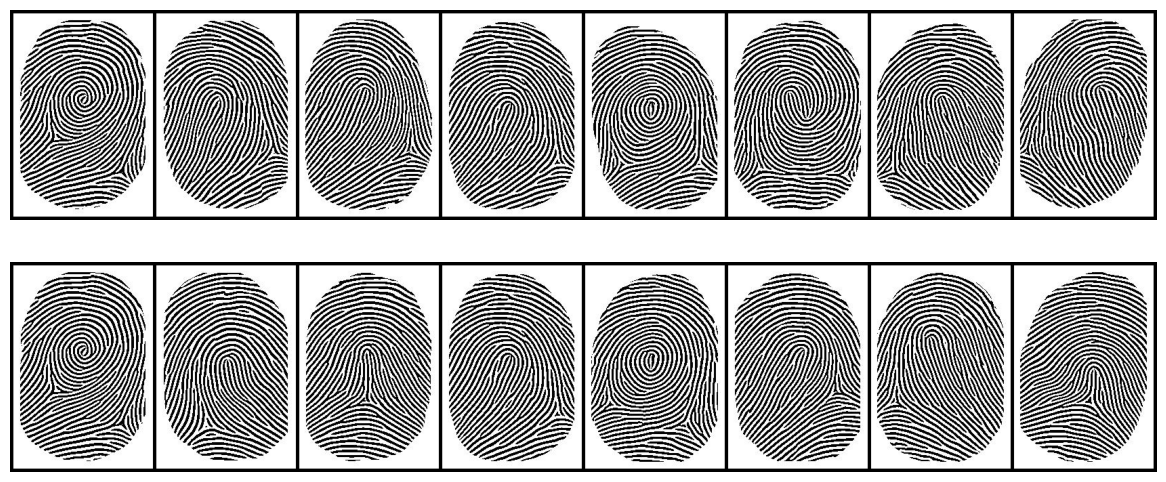

     same           diff          diff          same          same           diff          diff          diff     

In [8]:
showSampleFingerprintPairs(test_loader)

### Siamese Neural Network Training

In [9]:
### Siamese Neural Network Training
def train(netS, num_train, num_valid, train_loader, valid_loader, num_epochs, device, S_losses = []):
    start_epoch = 1
    # Lists to keep track of progress
    iters = 0

    print("\n[*] Train on {} sample pairs, validate on {} sample pairs".format(
        num_train, num_valid)
    )

    gLossMvAvg = MovingAvg()

    for epoch in range(start_epoch, num_epochs+1):
        print('\nEpoch: {}/{}'.format(epoch, num_epochs)) 
        # switch to train mode
        netS.train()
        train_batch_time = AverageMeter()
        train_losses = AverageMeter()
        tic = time.time()
        training_accuracy = 0.0
        num_correct = 0
        total = 0
        with tqdm(total=num_train) as pbar:
            for i, (x1, x2, y) in enumerate(train_loader): 
                x1, x2, y = x1.to(device), x2.to(device), y.to(device)
                output = netS(x1, x2).view(-1)
                y = y.view(-1)
                errS = criterion(output, y)
                # Calculate the gradients for this batch
                errS.backward()
                # Update S
                optimizerS.step()

                for i in range(len(output)):
                    label = 0.0
                    if output[i] > 0.5:
                        label = 1.0
                    if label == y[i]:
                        num_correct += 1
                    total += 1

                training_accuracy = num_correct / total * 100

                # store batch statistics
                toc = time.time()
                train_batch_time.update(toc-tic)
                tic = time.time()
                pbar.set_description(
                    (
                        "loss_S: {:.3f}   training accuracy: {:.6f}".format(errS.item(), training_accuracy)
                    )
                )
                pbar.update(batch_size)

                # Save Losses for plotting later
                S_losses.append(errS.item())
                iters +=1

        # Validate
        netS.eval()
        validation_accuracy = 0.0
        num_valid_correct = 0
        total_valid = 0
        for i, (x1, x2, y) in enumerate(valid_loader): 
            x1, x2, y = x1.to(device), x2.to(device), y.to(device)
            output = netS(x1, x2).view(-1)
            y = y.view(-1)

            for i in range(len(output)):
                label = 0.0
                if output[i] > 0.5:
                    label = 1.0
                if label == y[i]:
                    num_valid_correct += 1
                total_valid += 1

        validation_accuracy = num_valid_correct / total_valid * 100
        print("Validataion Accuracy:  {:.6f}".format(validation_accuracy))
    
    saveCkpt(model_results_file, 1, netS, optimizerS, S_losses, iters)    
    return S_losses
        

In [10]:
### Siamese Neural Network Training
S_losses = train(netS, num_train, num_valid, train_loader, valid_loader, num_epochs, device)


[*] Train on 10000 sample pairs, validate on 4000 sample pairs

Epoch: 1/1


loss_S: 0.400   training accuracy: 70.760000: : 10048it [00:20, 478.69it/s]                                                                                                                   


Validataion Accuracy:  89.025000


## Training Round 2

Next the model will be trained to match unenhanced good fingerprints to enhance fingerprint images. The hope is that this will help the network bridge the gap between matching enhanced fingerprint pairs to unenhanced fingerprint pairs.

### Set Training Params

In [11]:
## Training Round 2

### Set Training Params

# create data loaders
torch.manual_seed(1)
batch_size = 64

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': 1, 'pin_memory': True}
    
target_dir =  data_base_dir + "Prepped_Fingerprints_206x300_reformated/Good/"
template_dir = data_base_dir + "Prepped_Fingerprints_206x300_reformated/Enhanced_Good/"

# Create the dataloader
data_loader = get_train_valid_test_loaders(target_dir, template_dir, batch_size, num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader[0]
valid_loader = data_loader[1]
test_loader = data_loader[2]

criterion = nn.BCELoss()

slr = 0.00002

# Setup Adam optimizers for S
optimizerS = optim.Adam(netS.parameters(), lr=slr, betas=(beta1, 0.999))

num_epochs = 1

### Data Visualization

Below are some sample images that the Fingerprint Siamese Neural Network will be trained on. The top row consists of the unenhanced good quality fingerprints, which is a subset of the dataset consisting of around 100,000 fingerprint images with 10,000 unique fingerprints. The bottom row consists of the enhanaced fingerprint images, which is a different subset of the dataset that also consists of around 100,000 fingerprint images containing the same 10,000 unique fingerprints as the perviously described subset. Please note that the enhanced fingerprint subset was generated from the unenhanced good fingerprint subset using Gabor Filters. 

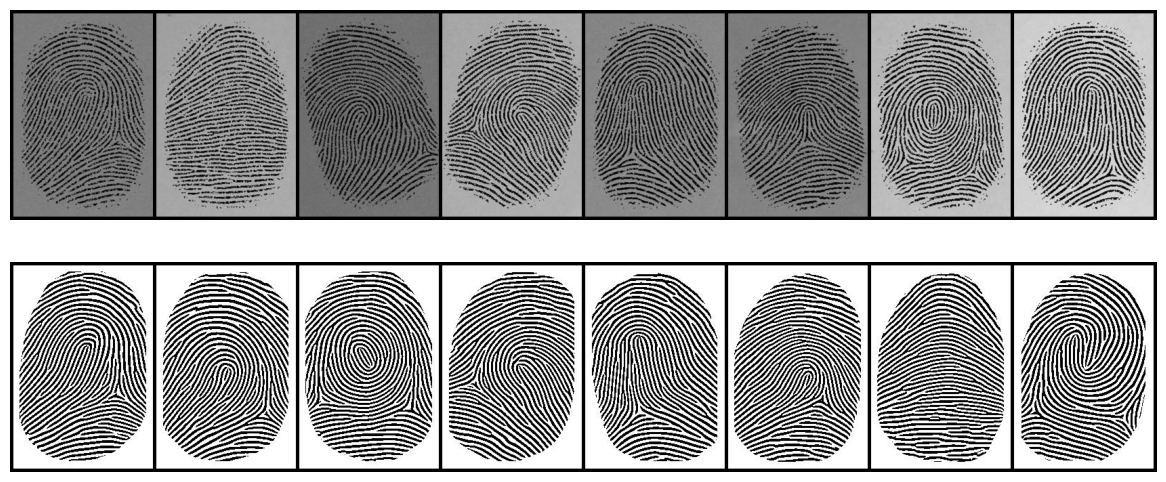

     same           diff          diff          same          same           diff          diff          diff     

In [12]:
showSampleFingerprintPairs(test_loader)

### Siamese Neural Network Training

In [13]:
### Siamese Neural Network Training
S_losses = train(netS, num_train, num_valid, train_loader, valid_loader, num_epochs, device)


[*] Train on 10000 sample pairs, validate on 4000 sample pairs

Epoch: 1/1


loss_S: 0.045   training accuracy: 91.400000: : 10048it [00:20, 500.28it/s]                                                                                                                   


Validataion Accuracy:  91.150000


## Training Round 3

The model will be trained to match bad unenhanced fingerprint pairs of varying qualities.

### Set Training Params

In [14]:
## Training Round 3

### Set Training Params

# create data loaders
torch.manual_seed(1)
batch_size = 256

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': 1, 'pin_memory': True}
    
target_dir =  data_base_dir + "Prepped_Fingerprints_206x300_reformated/Bad/"
template_dir = data_base_dir + "Prepped_Fingerprints_206x300_reformated/Bad/"

# Create the dataloader
num_train = 100000
num_valid = 4000
data_loader = get_train_valid_test_loaders(target_dir, template_dir, batch_size, num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader[0]
valid_loader = data_loader[1]
test_loader = data_loader[2]

criterion = nn.BCELoss()

slr = 0.00002

# Setup Adam optimizers for S
optimizerS = optim.Adam(netS.parameters(), lr=slr, betas=(beta1, 0.999))

num_epochs = 15

### Data Visualization

Below are some sample images that the Fingerprint Siamese Neural Network will be trained on, which is a larger subset containing around 800,000 unenhanced fingerprint images of varying qualityies from really good to really bad.

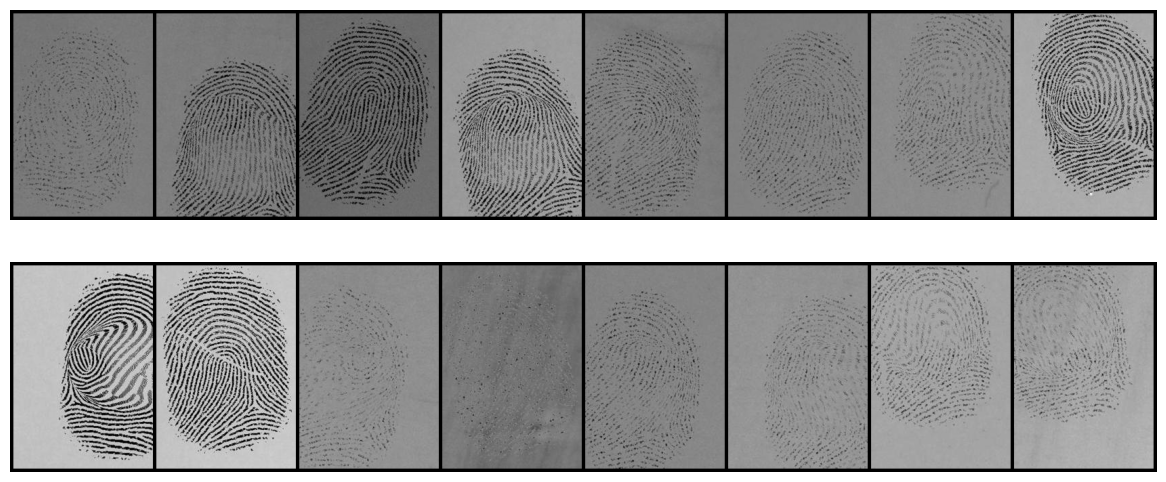

     same           diff          diff          same          diff           same          diff          same     

In [15]:
showSampleFingerprintPairs(test_loader)

### Siamese Neural Network Training

In [16]:
### Siamese Neural Network Training
S_losses = train(netS, num_train, num_valid, train_loader, valid_loader, num_epochs, device)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 1/15


loss_S: 0.606   training accuracy: 65.460000: : 100096it [03:29, 476.65it/s]                                                                                                                  


Validataion Accuracy:  69.700000

Epoch: 2/15


loss_S: 0.501   training accuracy: 77.672000: : 100096it [03:31, 474.22it/s]                                                                                                                  


Validataion Accuracy:  81.675000

Epoch: 3/15


loss_S: 0.231   training accuracy: 86.394000: : 100096it [03:29, 477.81it/s]                                                                                                                  


Validataion Accuracy:  87.700000

Epoch: 4/15


loss_S: 0.236   training accuracy: 89.556000: : 100096it [03:27, 482.15it/s]                                                                                                                  


Validataion Accuracy:  90.275000

Epoch: 5/15


loss_S: 0.267   training accuracy: 91.559000: : 100096it [03:28, 479.64it/s]                                                                                                                  


Validataion Accuracy:  92.700000

Epoch: 6/15


loss_S: 0.775   training accuracy: 92.396000: : 100096it [03:30, 474.96it/s]                                                                                                                  


Validataion Accuracy:  91.425000

Epoch: 7/15


loss_S: 0.375   training accuracy: 93.086000: : 100096it [03:28, 479.24it/s]                                                                                                                  


Validataion Accuracy:  94.650000

Epoch: 8/15


loss_S: 0.108   training accuracy: 93.445000: : 100096it [03:12, 520.51it/s]                                                                                                                  


Validataion Accuracy:  94.375000

Epoch: 9/15


loss_S: 0.187   training accuracy: 93.789000: : 100096it [03:18, 504.75it/s]                                                                                                                  


Validataion Accuracy:  93.475000

Epoch: 10/15


loss_S: 0.105   training accuracy: 94.092000: : 100096it [03:19, 501.64it/s]                                                                                                                  


Validataion Accuracy:  95.400000

Epoch: 11/15


loss_S: 0.168   training accuracy: 94.257000: : 100096it [03:34, 467.60it/s]                                                                                                                  


Validataion Accuracy:  96.075000

Epoch: 12/15


loss_S: 0.118   training accuracy: 94.528000: : 100096it [03:27, 482.62it/s]                                                                                                                  


Validataion Accuracy:  95.300000

Epoch: 13/15


loss_S: 0.119   training accuracy: 95.618000: : 100096it [03:24, 490.22it/s]                                                                                                                  


Validataion Accuracy:  96.075000

Epoch: 14/15


loss_S: 0.192   training accuracy: 95.545000: : 100096it [03:25, 487.70it/s]                                                                                                                  


Validataion Accuracy:  95.425000

Epoch: 15/15


loss_S: 0.222   training accuracy: 95.354000: : 100096it [03:23, 491.11it/s]                                                                                                                  


Validataion Accuracy:  95.225000


## Training Round 4

Next the model will be trained to match unenhanced bad fingerprints to enhance fingerprint images. 

In [20]:
## Training Round 4

### Set Training Params

# create data loaders
torch.manual_seed(1)
batch_size = 256

kwargs = {}
if device.type == 'cuda':
    torch.cuda.manual_seed(1)
    kwargs = {'num_workers': 1, 'pin_memory': True}
    
target_dir =  data_base_dir + "Prepped_Fingerprints_206x300_reformated/Bad/"
template_dir = data_base_dir + "Prepped_Fingerprints_206x300_reformated/Enhanced_Good/"

# Create the dataloader
num_train = 100000
num_valid = 4000
data_loader = get_train_valid_test_loaders(target_dir, template_dir, batch_size, num_train, num_valid, shuffle, **kwargs)

train_loader = data_loader[0]
valid_loader = data_loader[1]
test_loader = data_loader[2]

criterion = nn.BCELoss()

slr = 0.00002

# Setup Adam optimizers for S
optimizerS = optim.Adam(netS.parameters(), lr=slr, betas=(beta1, 0.999))

num_epochs = 2

### Data Visualization

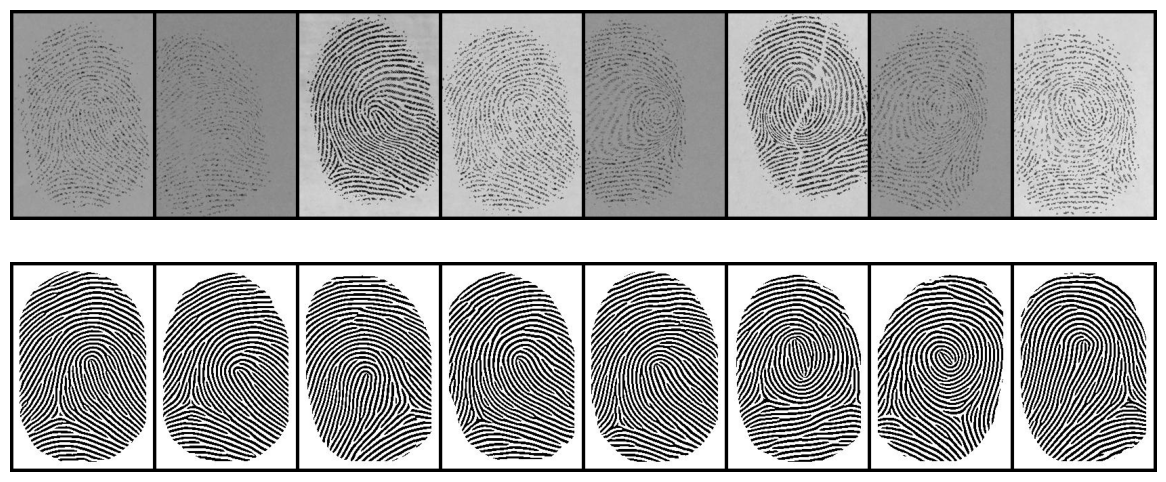

     same           diff          diff          same          diff           same          diff          diff     

In [21]:
showSampleFingerprintPairs(test_loader)

### Siamese Neural Network Training

In [22]:
### Siamese Neural Network Training
S_losses = train(netS, num_train, num_valid, train_loader, valid_loader, num_epochs, device)


[*] Train on 100000 sample pairs, validate on 4000 sample pairs

Epoch: 1/2


loss_S: 0.097   training accuracy: 97.283000: : 100096it [03:08, 531.71it/s]                                                                                                                  


Validataion Accuracy:  96.200000

Epoch: 2/2


loss_S: 0.062   training accuracy: 97.616000: : 100096it [03:08, 530.21it/s]                                                                                                                  


Validataion Accuracy:  92.175000


## Results

### Training Loss

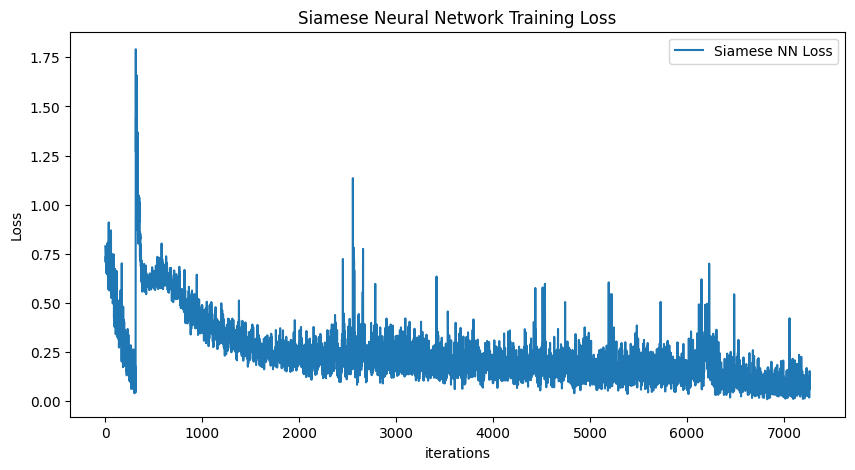

In [23]:
def plotTrainingLoss(S_losses):
    plt.figure(figsize=(10,5))
    plt.title("Siamese Neural Network Training Loss")
    plt.plot(S_losses,label="Siamese NN Loss")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
plotTrainingLoss(S_losses)

## Sample Performance
Below is plotted 8 pairs of fingerprints. Below each pair of fingerprints, the model will gives its prediction of whether each pair are of the same fingerprint or not. Below that is listed the ground truth.

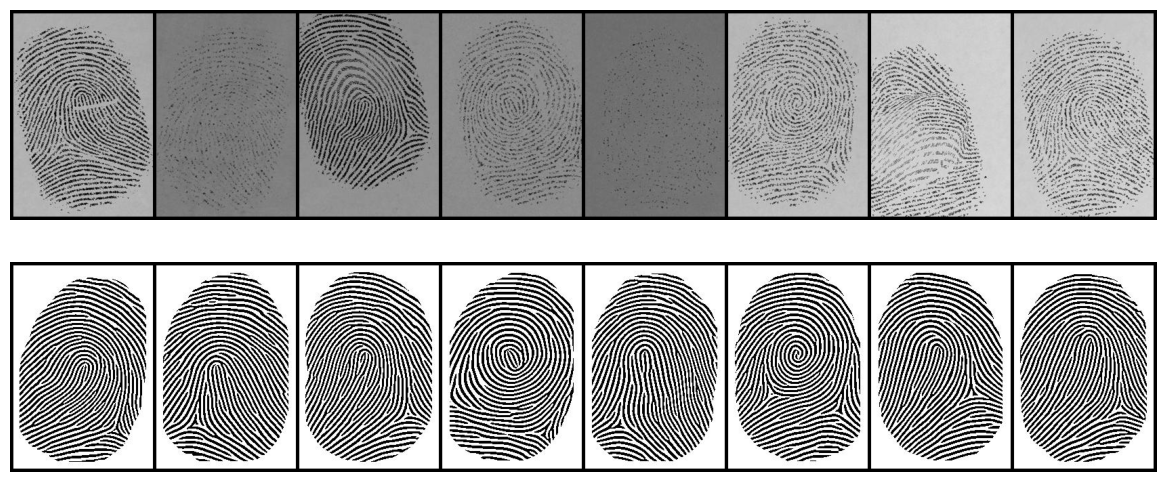

Pred: 
      diff           diff          same          same          diff           same          diff          diff    

Truth:
      diff           diff          same          same          diff           same          diff          diff    

Matching Accuracy over Test Dataset: 93.42%


In [24]:
def printLabels(labels):
    c = 0
    for l in labels:
        if l == 1:
            print("      same    ", end="")
        else:
            print("      diff    ", end="")
        if c % 4 == 0:
            print(" ", end="")
        c += 1
    print("\n")
    
    
def test(netS, loader, device):
    # Validate
    netS.eval()
    validation_accuracy = 0.0
    num_valid_correct = 0
    total_valid = 0
    for i, (x1, x2, y) in enumerate(loader): 
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        output = netS(x1, x2).view(-1)
        y = y.view(-1)

        for i in range(len(output)):
            label = 0.0
            if output[i] > 0.5:
                label = 1.0
            if label == y[i]:
                num_valid_correct += 1
            total_valid += 1

    validation_accuracy = num_valid_correct / total_valid * 100
    print("Matching Accuracy over Test Dataset: {:.2f}%".format(validation_accuracy))
    

def showTestPerformance(netS, test_loader, device):
    batch = next(iter(test_loader))
    labels = batch[2][:8]

    # Let model make predictions
    netS.eval()
    output = netS(batch[0].to(device)[:8], batch[1].to(device)[:8]).view(-1)

    # Display the Sample Images
    plt.figure(figsize=(20,6))
    plt.subplot(2,1,1)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))

    plt.subplot(2,1,2)
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:8], padding=5, normalize=True).cpu(),(1,2,0)))
    plt.show()


    # Display Model Performance
    preds = [0 if x < 0.5 else 1 for x in output]

    print("Pred: ")
    printLabels(preds)

    print("Truth:")
    printLabels(labels)  
    
    test(netS, test_loader, device)
    
showTestPerformance(netS, test_loader, device)


## cGAN Config

In [78]:
# New Config for GAN
latent_dim = 805  
ngf = 64  
lambda_recon = 100.0  
gan_num_epochs = 50
gan_batch_size = 32
gan_slr = 0.0002
degraded_dir = data_base_dir + "Prepped_Fingerprints_206x300_reformated/Bad/"
enhanced_dir = data_base_dir + "Prepped_Fingerprints_206x300_reformated/Enhanced_Good/"
gan_model_file = "checkpoint/GAN_results.pt"
        

## Generator Architecture for the cGAN

The Generator in our Conditional GAN (cGAN) is responsible for producing enhanced, binary-like fingerprint images from degraded inputs. It operates as a decoder network, conditioned on the latent embedding extracted from the Siamese Neural Network's encoder. This ensures the output preserves the original fingerprint's identity and ridge structures while generating realistic enhancements resembling Gabor-filtered targets.

### Key Components
- **Input**: 805-dimensional latent vector from the Siamese encoder (flattened feature map).
- **Decoder Structure**: A series of transposed convolutional layers to upsample the latent back to the original image size (1 × 300 × 206), mirroring the encoder's downsampling.
  - FC Layer: Reshapes 805-dim input to 1×35×23 feature map.
  - TConv5: 1→512 filters, 4×4 kernel, stride 1, padding 1, output_padding (0,0), BatchNorm, LeakyReLU (0.2).
  - TConv4: 512→256, 4×4 kernel, stride 1, padding 1, output_padding (0,0), BatchNorm, LeakyReLU.
  - TConv3: 256→128, 4×4 kernel, stride 2, padding 1, output_padding (1,1), BatchNorm, LeakyReLU.
  - TConv2: 128→64, 4×4 kernel, stride 2, padding 1, output_padding (0,1), BatchNorm, LeakyReLU.
  - TConv1: 64→1, 4×4 kernel, stride 2, padding 1, output_padding (0,0), Tanh activation for normalized [-1,1] output.
- **Output**: Grayscale enhanced image, suitable for thresholding to binary ridges.
- **Training Integration**: Combined with adversarial (BCE) and reconstruction (L1) losses; frozen encoder ensures no backprop through feature extraction.


In [79]:
# Decoder for Generator (reverse the encoder convs)
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 1 * 35 * 23)  # Unflatten to match conv5 output shape
        self.tconv5 = nn.ConvTranspose2d(1, ndf * 8, 4, 1, 1, output_padding=(0, 0), bias=False)
        self.tconv4 = nn.ConvTranspose2d(ndf * 8, ndf * 4, 4, 1, 1, output_padding=(0, 0), bias=False)
        self.tconv3 = nn.ConvTranspose2d(ndf * 4, ndf * 2, 4, 2, 1, output_padding=(1, 1), bias=False)
        self.tconv2 = nn.ConvTranspose2d(ndf * 2, ndf, 4, 2, 1, output_padding=(0, 1), bias=False)
        self.tconv1 = nn.ConvTranspose2d(ndf, nc, 4, 2, 1, output_padding=(0, 0), bias=False)
        self.bn5 = nn.BatchNorm2d(ndf * 8)
        self.bn4 = nn.BatchNorm2d(ndf * 4)
        self.bn3 = nn.BatchNorm2d(ndf * 2)
        self.bn2 = nn.BatchNorm2d(ndf)

    def forward(self, z):
        out = self.fc(z).view(-1, 1, 35, 23)
        out = F.leaky_relu(self.bn5(self.tconv5(out)), 0.2)
        out = F.leaky_relu(self.bn4(self.tconv4(out)), 0.2)
        out = F.leaky_relu(self.bn3(self.tconv3(out)), 0.2)
        out = F.leaky_relu(self.bn2(self.tconv2(out)), 0.2)
        out = torch.tanh(self.tconv1(out))  # tanh for [-1,1] output
        return out

# Create models
encoder = netS  # Pre-trained SiameseNet (we'll use sub_forward)
decoder = Decoder().to(device)
decoder.apply(weights_init)

Decoder(
  (fc): Linear(in_features=805, out_features=805, bias=True)
  (tconv5): ConvTranspose2d(1, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (tconv4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
  (tconv2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(0, 1), bias=False)
  (tconv1): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Discriminator Architecture for the cGAN

The Discriminator in our Conditional GAN (cGAN) is a PatchGAN-style network that evaluates the realism of enhanced fingerprint images at a local patch level, rather than globally. This promotes sharp, detailed ridge textures in the generator's outputs. It is conditioned on the degraded input image by concatenating it with the (generated or real) enhanced image, allowing it to assess coherence between input and output.

### Key Components
- **Input**: Concatenated degraded + enhanced images (2 channels, size 300×206).
- **Convolutional Structure**: 5-layer conv net with LeakyReLU activations (negative slope 0.2) and batch normalization on layers 2-4.
  - Conv1: 2→64 filters, 4×4 kernel, stride 2, padding 1 → Output: 64×150×103
  - Conv2: 64→128, 4×4 kernel, stride 2, padding 1, BatchNorm, LeakyReLU → Output: 128×75×51
  - Conv3: 128→256, 4×4 kernel, stride 2, padding 1, BatchNorm, LeakyReLU → Output: 256×37×25
  - Conv4: 256→512, 4×4 kernel, stride 1, padding 1, BatchNorm, LeakyReLU → Output: 512×36×24
  - Conv5: 512→1, 4×4 kernel, stride 1, padding 1, Sigmoid → Output: 1×35×23 patch map (probabilities for ~70×70 receptive fields).
- **Output**: A feature map of patch-wise real/fake probabilities (averaged in loss for overall score).
- **Training Integration**: BCE loss on real vs. fake pairs; helps generator produce realistic enhancements without global artifacts.


In [80]:
# Discriminator (PatchGAN: outputs 30x30 map for local realism)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: concat(degraded, enhanced) -> 2 channels
        self.conv1 = nn.Conv2d(nc * 2, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 1, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, 1, 4, 1, 1, bias=False)  # Output patch map

    def forward(self, input_img, enhanced_img):
        x = torch.cat([input_img, enhanced_img], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))  # Patch probabilities
        return x

# Create models
netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (conv1): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
)

## Data Visualization

In [81]:
from skimage.metrics import peak_signal_noise_ratio as compute_psnr
from skimage.metrics import structural_similarity as compute_ssim

# Optimizers
optimizerG = optim.Adam(decoder.parameters(), lr=gan_slr, betas=(beta1, 0.999))  # Only train decoder (encoder frozen)
optimizerD = optim.Adam(netD.parameters(), lr=gan_slr, betas=(beta1, 0.999))

# Criterion
criterion_gan = nn.BCELoss()
criterion_recon = nn.L1Loss()  # For recon in [-1,1]

# Data loaders for GAN (paired) using the original loader
num_gan_train = 100000  # Oversample to account for filtering ~half the pairs (set to 2x desired effective same pairs)
num_gan_valid = 8000  # Similarly oversample for validation
shuffle = True
kwargs = {'num_workers': num_workers, 'pin_memory': device.type == 'cuda'}
data_loader = get_train_valid_test_loaders(degraded_dir, enhanced_dir, gan_batch_size, num_gan_train, num_gan_valid, shuffle, **kwargs)
train_loader = data_loader[0]
valid_loader = data_loader[1]
test_loader = data_loader[2]  # Unused, but returned by the function

# Get fixed test batch for visualization
fixed_batch = next(iter(test_loader))
fixed_degraded, fixed_real_enhanced, fixed_y = fixed_batch[0].to(device), fixed_batch[1].to(device), fixed_batch[2].to(device).view(-1)
fixed_mask = (fixed_y == 1.0)
fixed_degraded = fixed_degraded[fixed_mask][:8]  # Take first 8 same pairs
fixed_real_enhanced = fixed_real_enhanced[fixed_mask][:8]

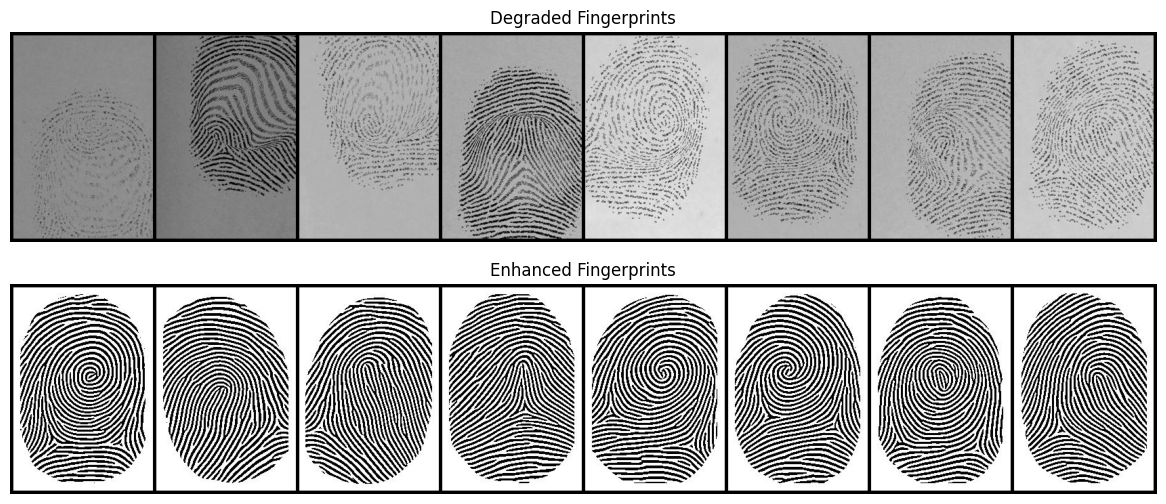

In [82]:
def showSampleFingerprintEnhancementPairs(loader):
    # Get a batch of sample pairs
    batch = next(iter(loader))
    degraded = batch[0][:8]  # Degraded images
    enhanced = batch[1][:8]  # Enhanced images
    
    # Display the sample images
    plt.figure(figsize=(20, 6))
    plt.subplot(2, 1, 1)
    plt.title("Degraded Fingerprints")
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(degraded.to(device), padding=5, normalize=True).cpu(), (1, 2, 0)))
    
    plt.subplot(2, 1, 2)
    plt.title("Enhanced Fingerprints")
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(enhanced.to(device), padding=5, normalize=True).cpu(), (1, 2, 0)))
    
    plt.show()

# Example: Visualize from the training loader
showSampleFingerprintEnhancementPairs(train_loader)

In [83]:
# GAN Training Function (modified to filter for same pairs only, ignoring y)
def train_gan(encoder, decoder, netD, num_train, num_valid, train_loader, valid_loader, num_epochs, device):
    encoder.eval()  # Freeze encoder
    G_losses = []
    D_losses = []
    iters = 0
    real_label = 1.0
    fake_label = 0.0
    print(f"\n[*] GAN Training on {num_train} pairs (effective ~{num_train//2} same pairs after filtering), validate on {num_valid} pairs")
    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch: {epoch}/{num_epochs}')
        decoder.train()
        netD.train()
        epoch_G_loss = 0.0
        epoch_D_loss = 0.0
        desc = f"Epoch {epoch}/{num_epochs}"
        for i, (degraded, real_enhanced, y) in enumerate(tqdm(train_loader, desc=desc)):
            degraded, real_enhanced, y = degraded.to(device), real_enhanced.to(device), y.to(device).view(-1)
            mask = (y == 1.0)  # Only use same fingerprint pairs
            if mask.sum() == 0:
                continue  # Skip empty batches
            degraded = degraded[mask]
            real_enhanced = real_enhanced[mask]
            batch_size = degraded.size(0)

            # Forward through encoder + decoder (Generator)
            with torch.no_grad():
                latent = encoder.sub_forward(degraded)
            fake_enhanced = decoder(latent)

            # Update Discriminator
            netD.zero_grad()
            # Real
            real_pair = netD(degraded, real_enhanced)
            errD_real = criterion_gan(real_pair, torch.full_like(real_pair, real_label, device=device))
            errD_real.backward()
            # Fake
            fake_pair = netD(degraded, fake_enhanced.detach())
            errD_fake = criterion_gan(fake_pair, torch.full_like(fake_pair, fake_label, device=device))
            errD_fake.backward()
            errD = (errD_real + errD_fake) / 2
            optimizerD.step()
            epoch_D_loss += errD.item()

            # Update Generator (decoder)
            decoder.zero_grad()
            fake_pair = netD(degraded, fake_enhanced)  # Recompute for G
            errG_gan = criterion_gan(fake_pair, torch.full_like(fake_pair, real_label, device=device))  # Fool D
            errG_recon = criterion_recon(fake_enhanced, real_enhanced)  # Reconstruction
            errG = errG_gan + lambda_recon * errG_recon
            errG.backward()
            optimizerG.step()
            epoch_G_loss += errG.item()

            # Logging
            if i % 500 == 0:
                print(f'[{epoch}/{num_epochs}][{i}/{len(train_loader)}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} Recon: {errG_recon.item():.4f}')
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            iters += 1

        # Average losses for epoch
        avg_G_loss = epoch_G_loss / len(train_loader)
        avg_D_loss = epoch_D_loss / len(train_loader)
        print(f"Epoch {epoch}: Avg D_loss = {avg_D_loss:.4f}, Avg G_loss = {avg_G_loss:.4f}")

        # Run validation
        metrics = run_validation(decoder, valid_loader, device)

        # Show sample images after each epoch
        with torch.no_grad():
            fake_disp = decoder(encoder.sub_forward(fixed_degraded)).detach().cpu()
        plt.figure(figsize=(20, 9))
        plt.subplot(3, 1, 1)
        plt.axis("off")
        plt.title("Degraded Fingerprints")
        plt.imshow(np.transpose(vutils.make_grid(fixed_degraded.cpu(), padding=5, normalize=True), (1, 2, 0)))
        
        plt.subplot(3, 1, 2)
        plt.axis("off")
        plt.title("GAN Enhanced Fingerprints")
        plt.imshow(np.transpose(vutils.make_grid(fake_disp, padding=5, normalize=True), (1, 2, 0)))
        
        plt.subplot(3, 1, 3)
        plt.axis("off")
        plt.title("True Enhanced Fingerprints (Gabor Filters)")
        plt.imshow(np.transpose(vutils.make_grid(fixed_real_enhanced.cpu(), padding=5, normalize=True), (1, 2, 0)))
        
        plt.show()

    # Save
    torch.save({
        'decoder_state_dict': decoder.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'G_losses': G_losses,
        'D_losses': D_losses,
    }, gan_model_file)
    return G_losses, D_losses

def run_validation(decoder, valid_loader, device):
    decoder.eval()
    total_psnr = 0
    total_ssim = 0
    num_samples = 0
    with torch.no_grad():
        for degraded, real_enhanced, y in valid_loader:
            degraded, real_enhanced, y = degraded.to(device), real_enhanced.to(device), y.to(device).view(-1)
            mask = (y == 1.0)
            if mask.sum() == 0:
                continue
            degraded = degraded[mask]
            real_enhanced = real_enhanced[mask]
            gan_enhanced = decoder(encoder.sub_forward(degraded))
            gan_enhanced_denorm = (gan_enhanced + 1) / 2
            real_enhanced_denorm = (real_enhanced + 1) / 2
            # Convert to numpy for skimage
            gan_np = gan_enhanced_denorm.cpu().numpy().squeeze()  # Assuming batch of grayscale
            real_np = real_enhanced_denorm.cpu().numpy().squeeze()
            batch_size = gan_np.shape[0]
            for j in range(batch_size):
                psnr = compute_psnr(gan_np[j], real_np[j], data_range=1.0)
                ssim = compute_ssim(gan_np[j], real_np[j], data_range=1.0)
                total_psnr += psnr
                total_ssim += ssim
            num_samples += batch_size
    if num_samples > 0:
        avg_psnr = total_psnr / num_samples
        avg_ssim = total_ssim / num_samples
        print(f"Validation: PSNR={avg_psnr:.4f}, SSIM={avg_ssim:.4f}")
        return {'avg_psnr': avg_psnr, 'avg_ssim': avg_ssim}
    else:
        print("No valid same pairs in validation; check data.")
        return {'avg_psnr': 0.0, 'avg_ssim': 0.0}


[*] GAN Training on 100000 pairs (effective ~50000 same pairs after filtering), validate on 8000 pairs

Epoch: 1/1


Epoch 1/1:   0%|▏                                                                                                                                            | 3/3125 [00:00<06:22,  8.17it/s]

[1/1][0/3125] Loss_D: 0.1054 Loss_G: 74.2433 Recon: 0.7101


Epoch 1/1:  16%|██████████████████████▎                                                                                                                    | 502/3125 [00:36<03:03, 14.26it/s]

[1/1][500/3125] Loss_D: 0.0707 Loss_G: 72.8273 Recon: 0.7012


Epoch 1/1:  32%|████████████████████████████████████████████▏                                                                                             | 1002/3125 [01:13<02:37, 13.44it/s]

[1/1][1000/3125] Loss_D: 0.0538 Loss_G: 74.3612 Recon: 0.7134


Epoch 1/1:  48%|██████████████████████████████████████████████████████████████████▍                                                                       | 1504/3125 [01:50<01:59, 13.61it/s]

[1/1][1500/3125] Loss_D: 0.0826 Loss_G: 72.8026 Recon: 0.7020


Epoch 1/1:  64%|████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 2003/3125 [02:27<01:14, 15.11it/s]

[1/1][2000/3125] Loss_D: 0.0460 Loss_G: 74.7445 Recon: 0.7078


Epoch 1/1:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 2504/3125 [03:01<00:41, 14.81it/s]

[1/1][2500/3125] Loss_D: 0.0532 Loss_G: 74.0834 Recon: 0.7104


Epoch 1/1:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 3004/3125 [03:35<00:07, 15.52it/s]

[1/1][3000/3125] Loss_D: 0.0843 Loss_G: 74.9460 Recon: 0.7113


Epoch 1/1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3125/3125 [03:44<00:00, 13.94it/s]

Epoch 1: Avg D_loss = 0.1488, Avg G_loss = 73.8920


Validation: PSNR=4.7333, SSIM=0.2091


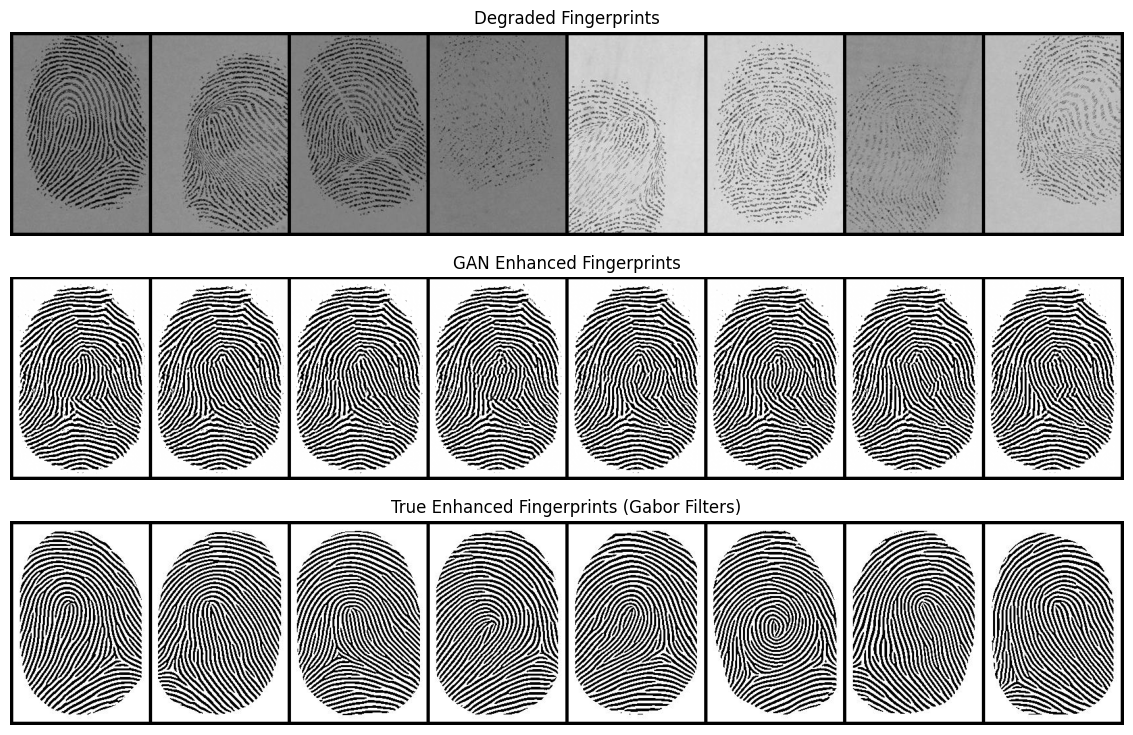

In [85]:
G_losses, D_losses = train_gan(encoder, decoder, netD, num_gan_train, num_gan_valid, train_loader, valid_loader, gan_num_epochs, device)

## Results

### Training Loss

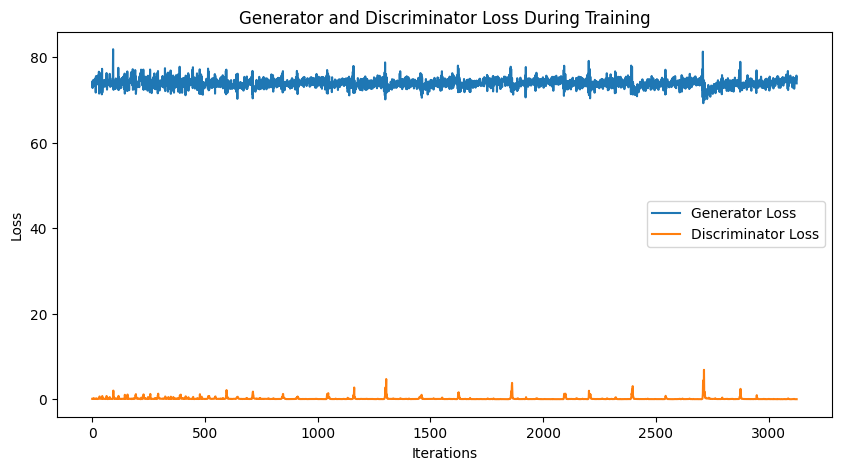

In [86]:
import matplotlib.pyplot as plt

# After training, plot the losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Side by Side Comparison of GAN Enhanced and Ideal Gabor Enhanced Fingerprint Images
* Top: Original Input Fingerprint Impressions
* Middle: GAN Enhanced Images
* Bottom: Ideal Gabor Enhanced Images

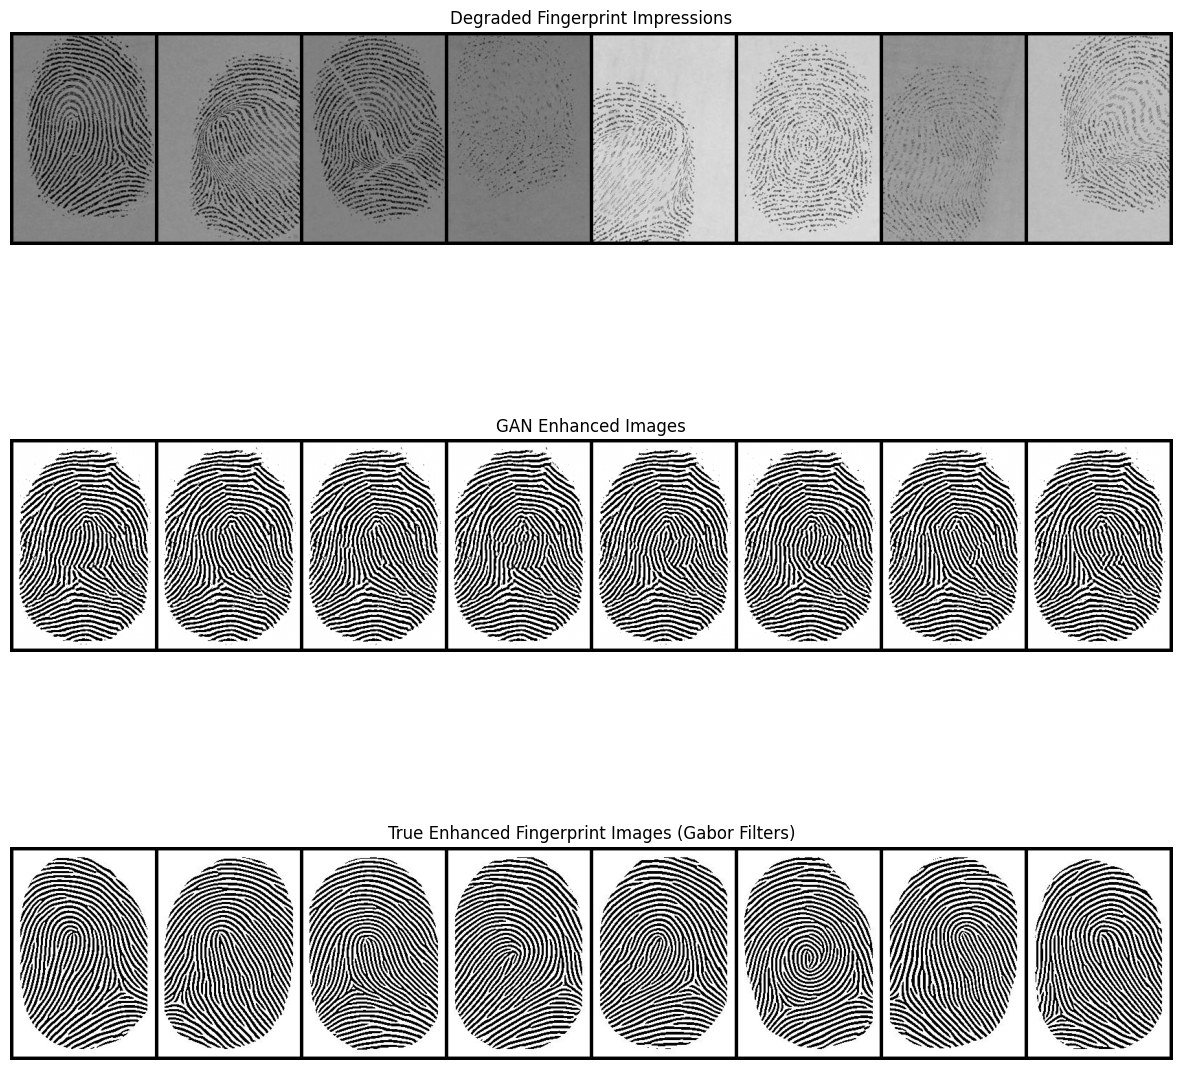

In [89]:
with torch.no_grad():
    fake_disp = decoder(encoder.sub_forward(fixed_degraded)).detach().cpu()

def displayComparison(degraded, gan_enhanced, real_enhanced):
    # Plot the degraded images
    plt.figure(figsize=(15,15))
    plt.subplot(3,1,1)
    plt.axis("off")
    plt.title("Degraded Fingerprint Impressions")
    plt.imshow(np.transpose(vutils.make_grid(degraded.cpu(), padding=5, normalize=True),(1,2,0)))
    
    # Plot the GAN enhanced images
    plt.subplot(3,1,2)
    plt.axis("off")
    plt.title("GAN Enhanced Images")
    plt.imshow(np.transpose(vutils.make_grid(gan_enhanced.cpu(), padding=5, normalize=True),(1,2,0)))
    
    # Plot the true enhanced images (ground truth)
    plt.subplot(3,1,3)
    plt.axis("off")
    plt.title("True Enhanced Fingerprint Images (Gabor Filters)")
    plt.imshow(np.transpose(vutils.make_grid(real_enhanced.cpu(), padding=5, normalize=True),(1,2,0)))
    
    plt.show()

# Example usage (after generating fake_disp in training loop)
displayComparison(fixed_degraded, fake_disp, fixed_real_enhanced)

# Conclusion

In this notebook, we implemented a Siamese-Conditioned cGAN for fingerprint enhancement, leveraging a pre-trained Siamese Neural Network (SNN) to extract identity-preserving features from degraded inputs and condition a cGAN generator to produce binary-enhanced images. The SNN effectively learned discriminative embeddings for matching, and the cGAN, with its PatchGAN discriminator and L1 reconstruction loss, generated visually appealing enhancements that resemble Gabor-filtered targets.

The results are promising: After training, the GAN-enhanced fingerprints exhibit clear ridge patterns and reduced noise, as seen in post-epoch visualizations. However, upon closer inspection, the reproduced ridge structures show discrepancies that would not improve downstream fingerprint matching accuracy compared to traditional methods.

### Limitations
- **Ridge Fidelity**: While visuals are good, subtle mismatches in minutiae and ridge continuity could limit practical utility in biometric systems.
- **Dataset Dependency**: Reliance on synthetic data (e.g., Anguli-generated) may not fully capture real-world variations.
- **Evaluation**: Current metrics (PSNR/SSIM) focus on perceptual similarity but don't directly assess matching performance.

### Future Work
To enhance ridge structure reproduction and boost matching efficacy, we can refine the loss function with additional criteria:
- **SNN-Based Matching Loss**: Integrate the Siamese network into the generator's loss by computing similarity scores between the GAN-enhanced image and the true enhanced target (or original good impression), penalizing deviations in embedding space.
- **NBIS Tool Integration**: Use tools from the NIST Biometric Image Software (NBIS), such as MINDTCT for minutiae extraction and BOZORTH3 for matching scores, as a differentiable or proxy loss to directly optimize for biometric compatibility.
- **Perceptual and Feature Losses**: Add VGG-based perceptual loss for high-level structural alignment and feature matching from the discriminator's intermediate layers to enforce ridge continuity.
- **Advanced Architectures**: Incorporate attention mechanisms or U-Net skips in the decoder for better local detail preservation; explore diffusion models as an alternative to GANs for stable training.
- **Real-World Testing**: Evaluate on authentic datasets (e.g., NIST SD4/SD14) and integrate end-to-end with a full matching pipeline to quantify improvements in False Match/Non-Match Rates.

Date: December 25, 2025  
Author: Dennis Kovarik